# Proyecto de redes neuronales profundas 
## Carol Edith Quiñones Sánchez 
### Proyecto sobre la estimación del Redshift apartir de la magnitud aparente usando el modelo LSTM y la base de datos de Kaggle: (https://www.kaggle.com/datasets/austinhinkel/hubble-law-astronomy-lab)


In [34]:
#Importación de librerias 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [35]:
import seaborn as sns
from sklearn.metrics import r2_score
import plotly.graph_objects as go

### LECTURA DE DATOS Y ANÁLISIS EXPLORATORIO

In [36]:
df = pd.read_csv('simulatedHubblesLawData.csv')
df

,apparent_magnitude,redshift
0,16.728844,0.040526
1,17.002490,0.047370
2,17.952543,0.069776
3,17.241295,0.052880
4,17.807425,0.065662
...,...,...
395,14.842944,0.016959
396,15.478982,0.021765
397,14.613858,0.014998
398,16.335897,0.033059


In [38]:
df.isna().sum() # Verifica na's

apparent_magnitude    0
redshift              0
dtype: int64

In [39]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   apparent_magnitude  400 non-null    float64
 1   redshift            400 non-null    float64
dtypes: float64(2)
memory usage: 6.4 KB


,apparent_magnitude,redshift
count,400.000000,400.000000
mean,16.647906,0.042865
std,1.025501,0.016882
min,14.004945,0.007873
25%,16.058557,0.029935
50%,16.893039,0.043526
75%,17.455681,0.056628
max,17.980166,0.077916


En primera estancia podemos observar que la base de dotos no posee valores nulos y todos son de tipo flotante.
Ademas, esta tiene un total de 400 Datos, para hacer predicciones de tipo LSTM puede que se requieran más datos.
Tambien podemos ver que la media esta centrada en la magnitud, el rango de magnitudes va desde aproximadamente de 14 a 18, lo cual en astronomía indica que son objetos tenues o moderadamente brillantes y no aparecen outliers.
Para el redshift se observa que los datos estan en un rango muy bajo lo que indica que las observaciones son del universo cercano, ademas como el corrimiento es bajo los efectos relativistas no dominan y se puede modelar de forma lineal el modelo.
Finalmente vemos que con este Datset se puede validar la Ley de Hubble lineal $v = H_0*d$.



## Grafica de Magnitud aparente vs Redshift

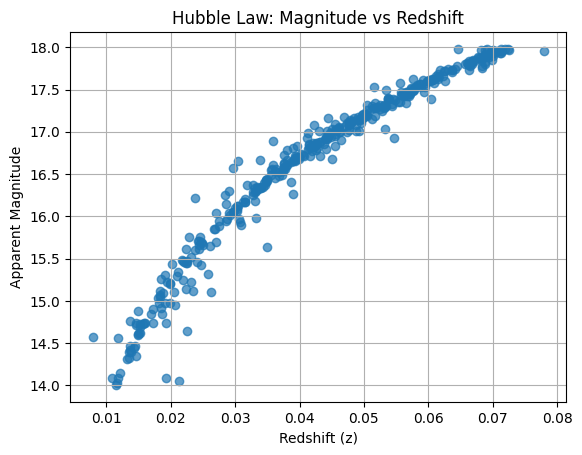

In [41]:
plt.scatter(df["redshift"], df["apparent_magnitude"], alpha=0.7)
plt.xlabel("Redshift (z)")
plt.ylabel("Apparent Magnitude")
plt.title("Hubble Law: Magnitude vs Redshift")
plt.grid(True)
plt.show()

En esta grafica se visualiza qu el eje X el redshift va desde 0.01 a 0.08 este quiere decir que la longitu de onda aumento del 1% hasta el 8% desde que fue emitida. En el eje y se muetra la magnitud aparente la cual va desde los 14 a 18.
Lo que muestra la gráfica es que conforme el obejeto este mas lejano el redshift va aumentando.
La tendencia de la grafica muestra que es creciente no es líneal, lo cual esperable dentro de la cosmología.

array([[<Axes: title={'center': 'apparent_magnitude'}>,
        <Axes: title={'center': 'redshift'}>, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

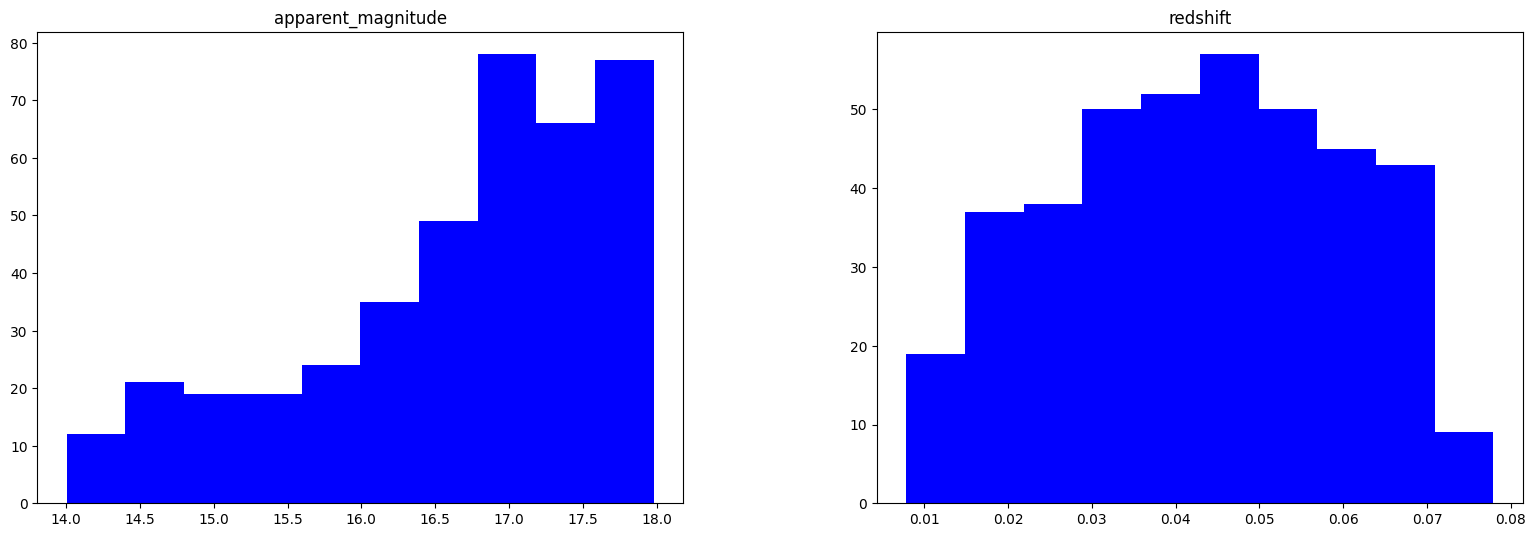

In [42]:
df.hist(figsize=(30,30), layout=(4,3), color='blue', grid= False)

En estos histogramas, notamos que para la magnitud aparente la distribución no es normal.
Se ve que hay una mayor concentración en los objetos de magnitud 16 a 18, lo cual muestra que la mayoria de los objetos son lejanos.
Para el redshift la distribución esta sesgada en forma de campana, con un pico entre 0.04 a 0.05 cuando el corrimiento es maypr a 0.07 se ve una caida muy notoria, lo que puede indicar una límitación en el telescopio o en el muestreo.

## Correlación

In [43]:
correlation = df["redshift"].corr(df["apparent_magnitude"])
print("Correlación redshift - magnitud:", correlation)


Correlación redshift - magnitud: 0.9633202084410457


#### Aquí se observa que tanto el redshift y la magnitud aparente tienen una alta correlación, por tanto se pueden hacer predicciones aplicando modelos de RNN.

# Preparación de datos para aplicar modelo de entrenamiento RNN/LSTM

## Crear secuencias para LSTM

In [44]:
############# Escalado de datos ####################

# Ordenar por redshift para mantener consistencia en series temporales
df = df.sort_values('redshift').reset_index(drop=True)
# Escalar ambos atributos
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['apparent_magnitude', 'redshift']])

# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        # Solo usamos la magnitud aparente como entrada
        X.append(data[i:i+time_steps, 0])  # columna 0 = magnitud aparente
        y.append(data[i+time_steps, 1])    # columna 1 = redshift
    return np.array(X), np.array(y)

# Crear dataset
X, y = create_dataset(df_scaled, time_steps=10)
# Adaptar forma para LSTM: [muestras, pasos de tiempo, características]
X = X.reshape((X.shape[0], X.shape[1], 1))


## Entrenamiento del modelo LSTM

In [45]:
# Modelo LSTM
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['accuracy'])


C:\Users\52221\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [46]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,901 (276.96 KB)

 Trainable params: 70,901 (276.96 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Entrenar el modelo
history = model.fit(X, y, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.0016 - loss: 0.0867
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 2.9740e-04 - loss: 0.0066
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 2.9740e-04 - loss: 0.0030
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.9724e-04 - loss: 9.7429e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0034 - loss: 7.6157e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0034 - loss: 6.2470e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0016 - loss: 0.0010    
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0027 - loss: 8.1346e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 7.4584e-04 - loss: 4.9764e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0043 - loss: 8.8691e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0020 - loss: 0.0015
Epoch 12/50
25/25 

#### Despues de realizar el entrenamiento notamos que en las 50 epocas el accuracy no tuvo ningun acercamiento a 1, lo que puede indicar que la red no se este entrenando adecuadamente, pero tambien vemos hay muy poca perdida en cada capa. Puede ser que no sean suficientes datos para el entrenamiento y se requieran más para mejorar el entrenamiento.

## Predicciones

In [48]:
# Hacer predicciones
pred_scaled = model.predict(X)

# Reconstruir el array para invertir el escalado
# Insertamos las predicciones en la columna 1 (redshift)
zeros = np.zeros((len(pred_scaled), 2))
zeros[:, 1] = pred_scaled[:, 0]

# Invertimos escalado
pred_inv = scaler.inverse_transform(zeros)
pred_redshift = pred_inv[:, 1]

# También invertimos los valores reales de redshift para comparar
y_full = np.zeros((len(y), 2))
y_full[:, 1] = y
y_real = scaler.inverse_transform(y_full)[:, 1]


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step


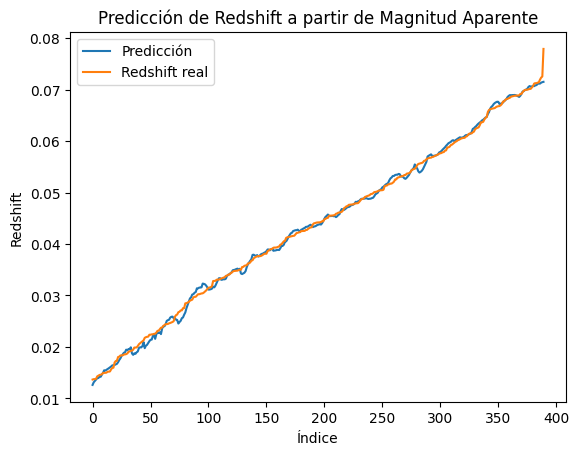

In [49]:
import matplotlib.pyplot as plt

plt.plot(pred_redshift, label='Predicción')
plt.plot(y_real, label='Redshift real')
plt.legend()
plt.title("Predicción de Redshift a partir de Magnitud Aparente")
plt.xlabel("Índice")
plt.ylabel("Redshift")
plt.show()


In [50]:

r2 = r2_score(y_real, pred_redshift)
print(f"R² score: {r2:.4f}")


R² score: 0.9979


### El valor de R^2 nos indica si el entrenamiento fue adeacuado, ya que esta cercano a 1, nos indica que el entrenamiento fue muy bueno. Por lo que el modelo explica el 99.79% de la variación en el redshift basado en la magnitud aparente.

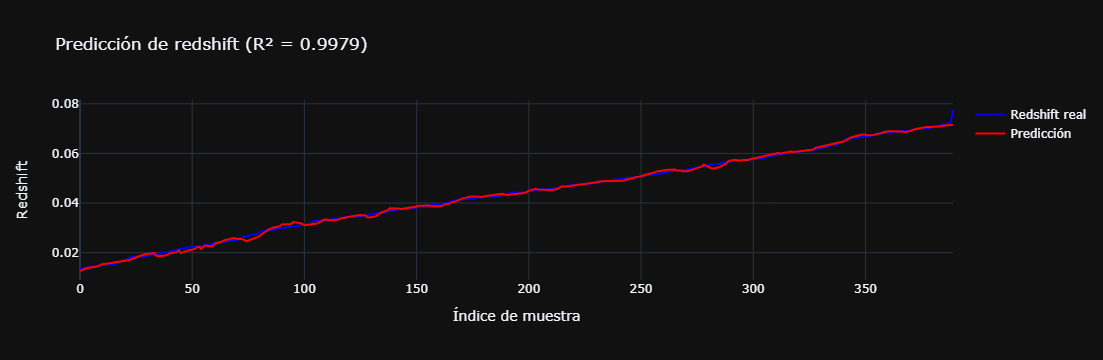

In [59]:

fig = go.Figure()

# Línea real
fig.add_trace(go.Scatter(
    y=y_real,
    mode='lines',
    name='Redshift real',
    line=dict(color='blue')
))

# Línea de predicción
fig.add_trace(go.Scatter(
    y=pred_redshift,
    mode='lines',
    name='Predicción',
    line=dict(color='red')
))

# Título y ejes
fig.update_layout(
    title=f"Predicción de redshift (R² = {r2:.4f})",
    xaxis_title="Índice de muestra",
    yaxis_title="Redshift",
    template='plotly_dark'
)

fig.show()


### Podemos concluir que el entranamiento realizado fue adecuado para hacer las predicciones correspondientes, vemos en la grafica como la predicción se asemeja al redshift real, por tanto al usar la magnitud aparente se puede hacer una buena estimación del redshift.